# Game of Drones on a Graph (0-7) - Section IV Formal Model

This section formalises the Game of Drones on a Graph by introducing a common structural model shared by both adversarial variants. Subsection IV-A presents the underlying graph-based version, including the cost vector formulation, risk assignments. Subection IV-B introduces the concept of lexicographic ordering as a realistic and operationally justified method to prioritise drone paths. Finally, subsections IV-C and IV-D then specify the normal-form and Stackelberg variants, respectively.

In [1]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import scipy.optimize
import latexify

print(f"Packages loaded with following versions\n\tJSON\t\t\t- {json.__version__}\n\tNetworkx\t\t- {nx.__version__}\n\tLatexify version\t- {latexify.__version__}")

Packages loaded with following versions
	JSON			- 2.0.9
	Networkx		- 3.5
	Latexify version	- 0.4.4


## IV-A Shared Graph 

Representation of a strategic game between a jammer and a drone on a graph. The graph represents a complex urban environment where the drone needs to navigate from a start to a target node.

The graph is defined as $G=(V,E)$ with the nodes reflecting decision points and the edges represent distances between the nodes. 


## Generate the Graph G through import from JSON file

Node attributes:
1: {'label': '1', 'color': 'green'}
2: {'label': '2', 'color': 'gray'}
3: {'label': '3', 'color': 'gray'}
4: {'label': '4', 'color': 'gray'}
5: {'label': '5', 'color': 'gray'}
6: {'label': '6', 'color': 'gray'}
7: {'label': '7', 'color': 'maroon'}

Edge attributes:
1->2: {'R': 0, 'L': 1}
1->4: {'R': 0, 'L': 1}
1->5: {'R': 0, 'L': 1}
2->3: {'R': 0, 'L': 1}
2->4: {'R': 0, 'L': 1}
3->7: {'R': 0, 'L': 1}
4->5: {'R': 0, 'L': 1}
4->6: {'R': 0, 'L': 1}
5->6: {'R': 0, 'L': 1}
6->7: {'R': 0, 'L': 1}


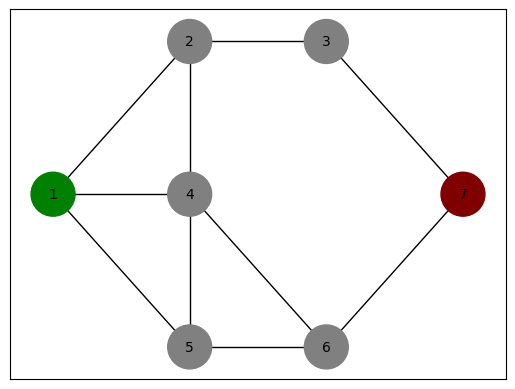

In [5]:
# define parameters
json_file = 'GoD_basic_graph.json'

# load a Graph from a JSON file, 
with open(json_file, 'r') as f:
    data = json.load(f)

G = nx.node_link_graph(data)


# Access the attributes of nodes and edges:
print("Node attributes:")
for node, attrs in G.nodes(data=True):
    print(f"{node}: {attrs}")

print("\nEdge attributes:")
for u, v, attrs in G.edges(data=True):
    print(f"{u}->{v}: {attrs}")


# Draw the graph
def show_graph(graph):
    node_labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'label')

    networkx_pos = {
        node_id: tuple(coords)  
        for node_id, coords in data['positions'].items() }

    node_colors = [node["color"] for node in data["nodes"]]

    nx.draw_networkx(G, pos=networkx_pos, with_labels=True, labels=node_labels, 
                     node_color=node_colors, node_size=1000, font_size=10)
    nx.draw_networkx_edge_labels(G, pos=networkx_pos, edge_labels=edge_labels)
    plt.show()


show_graph(G)

## Section V-A: List of viable paths

The list of viable paths comprises all paths from start node to finish node with a length < maximum range of the drone (B). The NETWORKX package allows finding all simple paths (so no recurring nodes) with a length of <= cutoff. Therefore we use (B+1) as the cutoff value.

In [68]:
total_paths = list(nx.all_simple_paths(G, "1", "7"))
B = 5

print("*** Total Paths in G ***")
count = 1
for p in total_paths:
    print(f"[{count}] - length = {len(p)-1} - path is {p}")
    count+=1



# generate a text file for Table II Simple Paths in section IV-A
def generate_latex_table_from_all_paths(total_paths, G, outfile="TabII_Simple_Paths.txt"):
    success = False
    with open(outfile, "w") as f:
        f.write("\\begin{table} [ht!] \n")
        f.write("\\renewcommand{\\arraystretch}{1.2} \n")
        f.write("\\caption{Simple paths from S to T for graph in Fig.~\\ref{fig:ExampleGraph}} \n")
        f.write("\\label{tab:SimplePathsExample} \n")
        f.write("\t\\centering \n")
        f.write("\t\\begin{tabular}{c c c} \\toprule \n")
        f.write("\t\\textbf{Path ID} & \\textbf{Route} & \\textbf{Length} \\\\ \\midrule \n")

        for idx, path in enumerate(total_paths, 1):
            # Format path string as "1–2–3–7"
            route = "–".join(path)

            # Compute path length based on edge weights
            path_length = sum(G.edges[u, v]['L'] for u, v in zip(path[:-1], path[1:]))

            # Write table row
            f.write(f"\t\t{idx} & {route} & {path_length} \\\\ \n")

            # Insert midrule after every 4 paths
            if idx % 4 == 0:
                f.write("\t\t\\midrule \n")

        f.write("\t\t\\bottomrule \n")
        f.write("\t\\end{tabular} \n")
        f.write("\\end{table}")
        success = True
    return (success, outfile)
        
success, tabIIfile = generate_latex_table_from_all_paths(total_paths, G)
if success:
    print(f"\nData for Table II succesfully captured in file {tabIIfile}")



# now generate the list of viable paths, so paths with number of edges <= B:
print("\n*** Viable Paths in G ***")
viable_paths = [p for p in total_paths if sum(G.edges[u, v]['L'] for u, v in zip(p[:-1], p[1:])) < B+1]
count = 1
for p in viable_paths:
    print(f"[{count}] - length = {len(p)} - path is {p}")
    count+=1
    

*** Total Paths in G ***
[1] - length = 3 - path is ['1', '2', '3', '7']
[2] - length = 5 - path is ['1', '2', '4', '5', '6', '7']
[3] - length = 4 - path is ['1', '2', '4', '6', '7']
[4] - length = 4 - path is ['1', '4', '2', '3', '7']
[5] - length = 4 - path is ['1', '4', '5', '6', '7']
[6] - length = 3 - path is ['1', '4', '6', '7']
[7] - length = 5 - path is ['1', '5', '4', '2', '3', '7']
[8] - length = 4 - path is ['1', '5', '4', '6', '7']
[9] - length = 6 - path is ['1', '5', '6', '4', '2', '3', '7']
[10] - length = 3 - path is ['1', '5', '6', '7']

Data for Table II succesfully captured in file TabII_Simple_Paths.txt

*** Viable Paths in G ***
[1] - length = 4 - path is ['1', '2', '3', '7']
[2] - length = 6 - path is ['1', '2', '4', '5', '6', '7']
[3] - length = 5 - path is ['1', '2', '4', '6', '7']
[4] - length = 5 - path is ['1', '4', '2', '3', '7']
[5] - length = 5 - path is ['1', '4', '5', '6', '7']
[6] - length = 4 - path is ['1', '4', '6', '7']
[7] - length = 6 - path is [

In [53]:
total_paths

[['1', '2', '3', '7'],
 ['1', '2', '4', '5', '6', '7'],
 ['1', '2', '4', '6', '7'],
 ['1', '4', '2', '3', '7'],
 ['1', '4', '5', '6', '7'],
 ['1', '4', '6', '7'],
 ['1', '5', '4', '2', '3', '7'],
 ['1', '5', '4', '6', '7'],
 ['1', '5', '6', '4', '2', '3', '7'],
 ['1', '5', '6', '7']]

## Section V-A: Value of Lexicographic Ordering

We apply formula (31) from the paper, which assigns a scalar value to each path. This value is based on the edge risks and total length of the path.

In this case, $\gamma=1000$ and $B=5$.

For the particular risks induced by a jammer at the selected node, we use:
\begin{equation}
    u(p,j) = 
    \begin{cases}
        - \frac {\gamma R(p) + L(p)} {\gamma + B} \quad \text{ if L<B} \\
        - \infty \quad \text{otherwise}
    \end{cases}
\end{equation}

In [15]:
def lexord_utility(path, jammedG):
    pass

## Jamming the Graph

This sections defines the threat model resulting from a deployed jammer to one of the nodes in the graph. We apply a simple jammer model with the following characteristics, as per eq. 30 of the paper:

\begin{equation}
    r^{(j)}_{uv} = 
    \begin{cases}
        0.5 & \text{if } u=i \text{ or } v=j \\
        0 & \text{otherwise}
    \end{cases}
\end{equation}


In [14]:
# all node but the start and end node can be jammer nodes:
jammer_nodes = [f"{i}" for i in [2,3,4,5,6]]
                
def jammed_graph(G, )

for u, v in G.edges():
    print(u, v, G.edges[u,v]['R'])


['2', '3', '4', '5', '6']
1 2 0
1 4 0
1 5 0
2 3 0
2 4 0
3 7 0
4 5 0
4 6 0
5 6 0
6 7 0


## Generate probability graph conditioned by jammer position.

In the previous section we have generated a clean, new graph with all risks p=0. In this section, we use the clean graph and modify the graph to edge risks for a given jammer position.


create_probability_graph | [u,v] = [1,2], distances are inf, inf
create_probability_graph | [u,v] = [1,4], distances are inf, inf
create_probability_graph | [u,v] = [1,5], distances are inf, inf
create_probability_graph | [u,v] = [2,3], distances are inf, inf
create_probability_graph | [u,v] = [2,4], distances are inf, inf
create_probability_graph | [u,v] = [3,7], distances are inf, inf
create_probability_graph | [u,v] = [4,5], distances are inf, inf
create_probability_graph | [u,v] = [4,6], distances are inf, inf
create_probability_graph | [u,v] = [5,6], distances are inf, inf
create_probability_graph | [u,v] = [6,7], distances are inf, inf


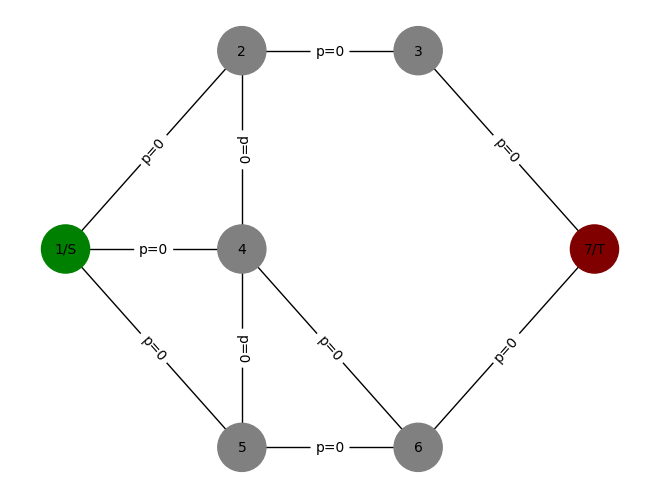

create_probability_graph | [u,v] = [1,2], distances are inf, inf
create_probability_graph | [u,v] = [1,4], distances are inf, inf
create_probability_graph | [u,v] = [1,5], distances are inf, inf
create_probability_graph | [u,v] = [2,3], distances are inf, inf
create_probability_graph | [u,v] = [2,4], distances are inf, inf
create_probability_graph | [u,v] = [3,7], distances are inf, inf
create_probability_graph | [u,v] = [4,5], distances are inf, inf
create_probability_graph | [u,v] = [4,6], distances are inf, inf
create_probability_graph | [u,v] = [5,6], distances are inf, inf
create_probability_graph | [u,v] = [6,7], distances are inf, inf


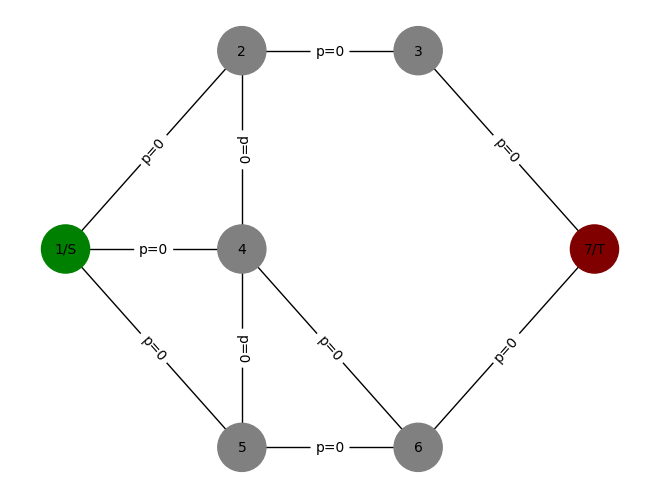

create_probability_graph | [u,v] = [1,2], distances are inf, inf
create_probability_graph | [u,v] = [1,4], distances are inf, inf
create_probability_graph | [u,v] = [1,5], distances are inf, inf
create_probability_graph | [u,v] = [2,3], distances are inf, inf
create_probability_graph | [u,v] = [2,4], distances are inf, inf
create_probability_graph | [u,v] = [3,7], distances are inf, inf
create_probability_graph | [u,v] = [4,5], distances are inf, inf
create_probability_graph | [u,v] = [4,6], distances are inf, inf
create_probability_graph | [u,v] = [5,6], distances are inf, inf
create_probability_graph | [u,v] = [6,7], distances are inf, inf


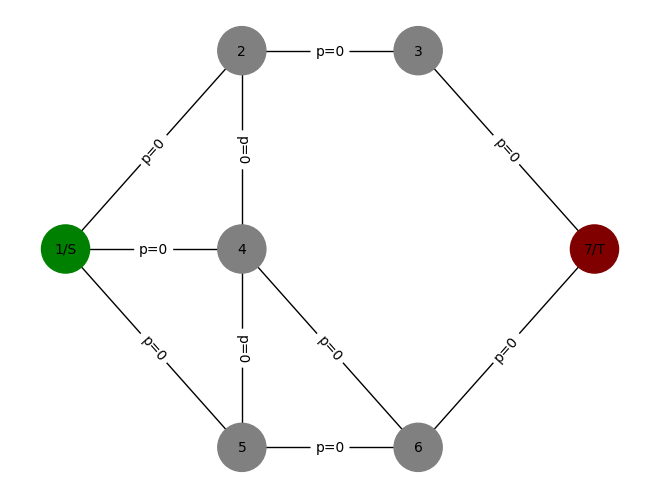

In [46]:
def create_probability_graph(graph, jammer):
    """ Given a graph and  """
    
    prob_graph = nx.Graph()
    for u, v in graph.edges():
        distance_u = nx.shortest_path_length(graph, source=jammer, target=u) if jammer in graph else float('inf')
        distance_v = nx.shortest_path_length(graph, source=jammer, target=v) if jammer in graph else float('inf')
        print(f"create_probability_graph | [u,v] = [{u},{v}], distances are {distance_u}, {distance_v}")

        min_distance = min(distance_u, distance_v)
        if min_distance == 0:
            prob = 0.5
        elif min_distance == 1:
            prob = 0.25
        else:
            prob = 0.0

        prob_graph.add_edge(u, v, survival_prob=1 - prob)
    return prob_graph

def calculate_risk(path, prob_graph):
    success_prob = 1.0
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        success_prob *= prob_graph[u][v]['survival_prob']
    return 1 - success_prob

def compute_payoff_matrix(graph, start, end, alpha):
    all_paths = list(nx.all_simple_paths(graph, source=start, target=end))
    max_length = max(len(path) - 1 for path in all_paths)

    payoff_matrix = {}
    for jammer in graph.nodes:
        prob_graph = create_probability_graph(graph, jammer)
        payoff_matrix[jammer] = {}

        for path in all_paths:
            risk = calculate_risk(path, prob_graph)
            length = len(path) - 1
            payoff = alpha * risk + (1 - alpha) * ((max_length - length) / max_length)
            payoff_matrix[jammer][tuple(path)] = payoff

    return payoff_matrix, all_paths


for jam_node in [2, 3, 4]:
    jammed_graph = create_probability_graph(G, jam_node)
    show_graph(jammed_graph)